In [1]:
pip install transformers datasets torch pandas numpy scikit-learn matplotlib seaborn

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_scheduler
from datasets import load_dataset
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
dataset = load_dataset('snli')
train_df = pd.DataFrame(dataset['train'])
val_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/550152 [00:00<?, ? examples/s]

In [4]:
train_df

,premise,hypothesis,label
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,1
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",2
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",0
3,Children smiling and waving at camera,They are smiling at their parents,1
4,Children smiling and waving at camera,There are children present,0
...,...,...,...
550147,Four dirty and barefooted children.,four kids won awards for 'cleanest feet',2
550148,Four dirty and barefooted children.,"four homeless children had their shoes stolen,...",1
550149,A man is surfing in a bodysuit in beautiful bl...,A man in a bodysuit is competing in a surfing ...,1
550150,A man is surfing in a bodysuit in beautiful bl...,A man in a business suit is heading to a board...,2


In [5]:
train_df.groupby('label').count()

,premise,hypothesis
label,,
-1,785,785
0,183416,183416
1,182764,182764
2,183187,183187


In [6]:
train_df=train_df[train_df['label']!=-1]

In [7]:
train_df.groupby('label').count()

,premise,hypothesis
label,,
0,183416,183416
1,182764,182764
2,183187,183187


In [8]:
train_df=train_df[:30000]

In [9]:
train_df

,premise,hypothesis,label
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,1
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",2
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",0
3,Children smiling and waving at camera,They are smiling at their parents,1
4,Children smiling and waving at camera,There are children present,0
...,...,...,...
30033,A woman and a boy sitting on a bus.,A bus is completely empty.,2
30034,A woman and a boy sitting on a bus.,A woman and a boy are sitting in the same row ...,1
30035,A woman and a boy sitting on a bus.,At least two people are sitting on a bus.,0
30036,Two ladies are sitting and there are pulses ar...,Two ladies are twerking.,2


In [10]:
val_df.groupby('label').count()

,premise,hypothesis
label,,
-1,158,158
0,3329,3329
1,3235,3235
2,3278,3278


In [11]:
val_df=val_df[val_df['label']!=-1]

In [12]:
val_df.groupby('label').count()

,premise,hypothesis
label,,
0,3329,3329
1,3235,3235
2,3278,3278


In [13]:
val_df=val_df[:5000]

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
def tokenize(df):
  return tokenizer(df['premise'].tolist(), df['hypothesis'].tolist(), truncation=True, padding='max_length', max_length=128)
train_encodings = tokenize(train_df)
val_encodings = tokenize(val_df)

In [16]:
class SNLIDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [17]:
train_dataset = SNLIDataset(train_encodings, train_df['label'].values)
val_dataset = SNLIDataset(val_encodings, val_df['label'].values)

In [18]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 3
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [21]:
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    name='linear',
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [22]:
best_val_accuracy = 0
early_stopping_patience = 3
patience_counter = 0

from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            val_preds.extend(torch.argmax(logits, dim=-1).cpu().numpy())
            val_labels.extend(batch['labels'].cpu().numpy())

    val_accuracy = accuracy_score(val_labels, val_preds)
    print(f"Epoch {epoch+1}: Validation Accuracy = {val_accuracy}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pt')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

  0%|          | 0/5625 [00:00<?, ?it/s]

Epoch 1: Validation Accuracy = 0.8374
Epoch 2: Validation Accuracy = 0.8504
Epoch 3: Validation Accuracy = 0.859


In [23]:
test_df

,premise,hypothesis,label
0,This church choir sings to the masses as they ...,The church has cracks in the ceiling.,1
1,This church choir sings to the masses as they ...,The church is filled with song.,0
2,This church choir sings to the masses as they ...,A choir singing at a baseball game.,2
3,"A woman with a green headscarf, blue shirt and...",The woman is young.,1
4,"A woman with a green headscarf, blue shirt and...",The woman is very happy.,0
...,...,...,...
9995,Two women are observing something together.,Two women are standing with their eyes closed.,2
9996,Two women are observing something together.,Two girls are looking at something.,0
9997,A man in a black leather jacket and a book in ...,A man is flying a kite.,2
9998,A man in a black leather jacket and a book in ...,A man is speaking in a classroom.,0


In [24]:
test_df.groupby('label').count()

,premise,hypothesis
label,,
-1,176,176
0,3368,3368
1,3219,3219
2,3237,3237


In [25]:
test_df=test_df[test_df['label']!=-1]

In [26]:
test_df=test_df[:5000]

In [27]:
test_df.groupby('label').count()

,premise,hypothesis
label,,
0,1702,1702
1,1657,1657
2,1641,1641


In [28]:
test_encodings = tokenize(test_df)

In [29]:
test_dataset = SNLIDataset(test_encodings, test_df['label'].values)

In [30]:
test_loader = DataLoader(test_dataset, batch_size=16)

In [31]:
def evaluate(loader):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds.extend(torch.argmax(logits, dim=-1).cpu().numpy())
            labels.extend(batch['labels'].cpu().numpy())
    return preds, labels

In [32]:
test_preds, test_labels = evaluate(test_loader)
test_accuracy = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.8602


In [33]:
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=['entailment', 'neutral', 'contradiction']))

Classification Report:
               precision    recall  f1-score   support

   entailment       0.88      0.88      0.88      1702
      neutral       0.82      0.82      0.82      1657
contradiction       0.88      0.88      0.88      1641

     accuracy                           0.86      5000
    macro avg       0.86      0.86      0.86      5000
 weighted avg       0.86      0.86      0.86      5000



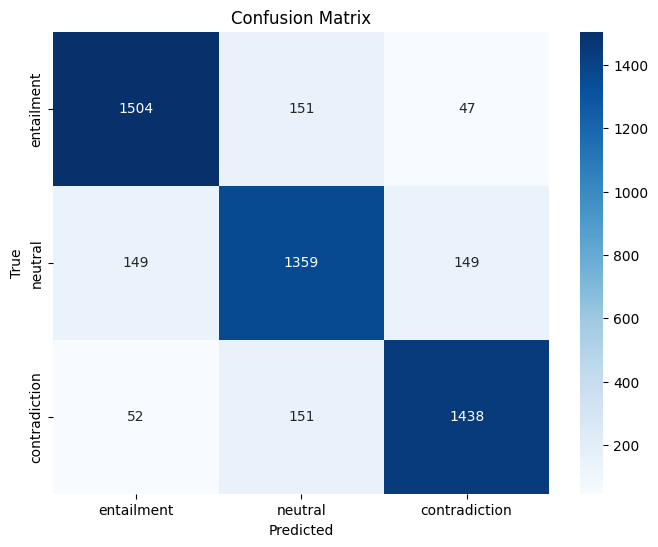

In [34]:
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['entailment', 'neutral', 'contradiction'], yticklabels=['entailment', 'neutral', 'contradiction'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [35]:
def predict(premise, hypothesis):
    inputs = tokenizer(premise, hypothesis, return_tensors='pt', truncation=True, padding='max_length', max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=-1).item()

    label_map = {0: 'entailment', 1: 'neutral', 2: 'contradiction'}
    return label_map[predicted_label]


In [36]:
premise_=input()
hypothesis_=input()

the ground is wet
it rained last night


In [37]:
predict(premise_,hypothesis_)

'neutral'

In [38]:
path=r"C:\Users\HP\Desktop\IITI_SoC"
model.save_pretrained(path)

In [39]:
loaded_model=BertForSequenceClassification.from_pretrained(path)

In [40]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
loaded_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [41]:
def predict_(premise, hypothesis):
    inputs = tokenizer(premise, hypothesis, return_tensors='pt', truncation=True, padding='max_length', max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = loaded_model(**inputs)

    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=-1).item()

    label_map = {0: 'entailment', 1: 'neutral', 2: 'contradiction'}
    return label_map[predicted_label]

In [42]:
predict_('he is a man', 'she is a woman')

'contradiction'